In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

## Classes and Functions

In [2]:
# 1. Define input and output paths
sim_dir = '../staging/runs/Matthew2016_v2b_mangrove/'# ../sims/Gonave_Surge_mangrove/'

fort13_path = sim_dir+'fort.13'  # Path to your fort.13 file
fort14_path = sim_dir+'fort.14'  # Path to your fort.14 file 
shapefile_path = '../datasets/mangrove_covers/refined/mangrove_polygon_refined.shp'  # Path to your shapefile with polygons
output_path = 'fort.13.updated'  # Path for the output file

/home/aesgeorges/anaconda3/envs/adcircpy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/aesgeorges/anaconda3/envs/adcircpy/lib/python3.11/site-packages/adcircpy/mesh/parsers/grd.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  output['nodes'] = pandas.read_csv(
/home/aesgeorges/anaconda3/envs/adcircpy/lib/python3.11/site-packages/adcircpy/mesh/parsers/grd.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  output['elements'] = pandas.read_csv(


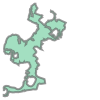

In [3]:
from adcircpy import AdcircMesh, AdcircRun, Tides
import shapefile
from shapely.geometry import Point, Polygon
# open mesh file
mesh = AdcircMesh.open('../datasets/meshes/ww_gonave_v2b_mangrove.grd', crs=4326)    
mesh.generate_tau0()

default_n = 0.025
n_values = np.full(mesh.coords.shape[0], default_n)
polygons = gpd.read_file(shapefile_path) 
polygons.geometry[0]

In [ ]:
def add_mannings_n_for_polygon(mesh, shapefile_path, mannings_n_value):
    """
    Add Manning's n values to mesh nodes within polygons from a shapefile.
    
    Parameters:
    -----------
    mesh : adcircpy.AdcircMesh
        ADCIRC mesh object
    shapefile_path : str
        Path to the shapefile containing polygons
    mannings_n_value : float
        Manning's n value to apply to all nodes within the polygons
    
    Returns:
    --------
    adcircpy.AdcircMesh
        The modified mesh object with updated Manning's n values
    """
    default_n = 0.025  # Default Manning's n value

    # Initialize Manning's n if it doesn't exist
    if not hasattr(mesh, 'mannings_n_at_sea_floor'):
        # Create an array with default values based on the number of rows in coords
        mesh.mannings_n_at_sea_floor = np.full(len(mesh.coords), default_n)
    
    # Load polygons from shapefile
    print(f"Loading polygons from {shapefile_path}...")
    polygons = gpd.read_file(shapefile_path)
    print(f"Loaded {len(polygons)} polygons")
    
    # Track total modified nodes
    total_modified = 0
    
    # Process each polygon
    node_values = np.array([])
    for idx, row in polygons.iterrows():
        polygon = row.geometry
        
        # Find and update nodes within this polygon
        count = 0
        if polygon is not None:
            for i, node_row in mesh.coords.iterrows():
                # Access coordinates using column names (adjust if different)
                x = node_row['x']  # Assuming column is named 'x'
                y = node_row['y']  # Assuming column is named 'y'
                
                point = Point(x, y)    
                if polygon.contains(point): # add new cover mannings
                    node_values = np.append(node_values, mannings_n_value)
                    #mesh.mannings_n_at_sea_floor[i] = mannings_n_value
                    count += 1
                else: # add default mannings
                    node_values = np.append(node_values, default_n)
        else:
            print(f"Polygon {idx} is None, skipping...")
            continue
        # Update the mesh's mannings_n_at_sea_floor array
        node_values = node_values.reshape(len(node_values), 1)
        mesh.mannings_n_at_sea_floor = node_values
        
        total_modified += count
        print(f"Polygon {idx}: Updated {count} nodes with Manning's n = {mannings_n_value}")
    
    print(f"Total nodes modified with non-default values: {total_modified}")
    return mesh, node_values

In [56]:
def add_mannings_n_for_multiple_polygons(mesh, shapefile_n_pairs):
    """
    Add Manning's n values to mesh nodes within polygons from multiple shapefiles.
    
    Parameters:
    -----------
    mesh : adcircpy.AdcircMesh
        ADCIRC mesh object
    shapefile_n_pairs : list of tuples
        List of tuples where each tuple contains:
        - shapefile_path (str): Path to the shapefile containing polygons
        - mannings_n_value (float): Manning's n value to apply to all nodes within the polygons
    
    Returns:
    --------
    adcircpy.AdcircMesh
        The modified mesh object with updated Manning's n values
    """
    default_n = 0.025  # Default Manning's n value

    # Initialize Manning's n if it doesn't exist
    #if not hasattr(mesh, 'mannings_n_at_sea_floor'):
     #   mesh.mannings_n_at_sea_floor = np.full(len(mesh.coords), default_n)
    
    # Track total modified nodes
    total_modified = 0
    
    node_values = np.full(mesh.values.shape, 0.025)
    # Process each shapefile and its corresponding Manning's n value
    for shapefile_path, mannings_n_value in shapefile_n_pairs:
        print(f"Processing shapefile: {shapefile_path} with Manning's n = {mannings_n_value}")
        
        # Load polygons from shapefile
        polygons = gpd.read_file(shapefile_path)
        print(f"Loaded {len(polygons)} polygons")
        
        # Process each polygon
        for idx, row in polygons.iterrows():
            polygon = row.geometry
            
            # Find and update nodes within this polygon
            count = 0
            if polygon is not None:
                for i, node_row in mesh.coords.iterrows():
                    x = node_row['x']  # Assuming column is named 'x'
                    y = node_row['y']  # Assuming column is named 'y'
                    
                    point = Point(x, y)
                    if polygon.contains(point):
                        node_values[i-1] = mannings_n_value
                        count += 1
            else:
                print(f"Polygon {idx} is None, skipping...")
                continue
            
            total_modified += count
            print(f"Polygon {idx}: Updated {count} nodes with Manning's n = {mannings_n_value}")
    # Update the mesh's mannings_n_at_sea_floor array
    mesh.mannings_n_at_sea_floor = node_values
    
    print(f"Total nodes modified with non-default values: {total_modified}")
    return mesh, node_values


In [59]:
mangrove_n = 0.2
mudflat_n = 0.016
sand_n = 0.015
urban_n = 0.15
crop_n = 0.08

shapefile_root = '../datasets/mangrove_covers/refined/'
# Define the shapefile and corresponding Manning's n values
pairs = [[shapefile_root+'mangrove_polygon_refined.shp', mangrove_n],
         [shapefile_root+'mudflat_polygon_refined.shp', mudflat_n],
         [shapefile_root+'sand_polygon_refined.shp', sand_n],
         [shapefile_root+'urban_polygon_refined.shp', urban_n],
         [shapefile_root+'crop_polygon_refined.shp', crop_n]]

In [60]:
mesh.mannings_n_at_sea_floor = np.full(mesh.values.shape, 0.025)

In [61]:
test, node_values = add_mannings_n_for_multiple_polygons(mesh, pairs)

Processing shapefile: ../datasets/mangrove_covers/refined/mangrove_polygon_refined.shp with Manning's n = 0.2
Loaded 3 polygons
Polygon 0: Updated 2974 nodes with Manning's n = 0.2
Polygon 1 is None, skipping...
Polygon 2 is None, skipping...
Processing shapefile: ../datasets/mangrove_covers/refined/mudflat_polygon_refined.shp with Manning's n = 0.016
Loaded 4 polygons
Polygon 0: Updated 460 nodes with Manning's n = 0.016
Polygon 1 is None, skipping...
Polygon 2 is None, skipping...
Polygon 3 is None, skipping...
Processing shapefile: ../datasets/mangrove_covers/refined/sand_polygon_refined.shp with Manning's n = 0.015
Loaded 5 polygons
Polygon 0: Updated 75 nodes with Manning's n = 0.015
Polygon 1 is None, skipping...
Polygon 2 is None, skipping...
Polygon 3: Updated 25 nodes with Manning's n = 0.015
Polygon 4: Updated 123 nodes with Manning's n = 0.015
Processing shapefile: ../datasets/mangrove_covers/refined/urban_polygon_refined.shp with Manning's n = 0.15
Loaded 1 polygons
Polygon

In [111]:
mesh, node_values = add_mannings_n_for_polygon(mesh, shapefile_path, 0.2)

Loading polygons from ../datasets/mangrove_covers/refined/mangrove_polygon_refined.shp...
Loaded 3 polygons
Polygon 0: Updated 2974 nodes with Manning's n = 0.2
Polygon 1 is None, skipping...
Polygon 2 is None, skipping...
Total nodes modified with non-default values: 2974


In [58]:
mesh_test = mesh.nodal_attributes.get_attribute('mannings_n_at_sea_floor').values()
list(mesh_test)[1].min(), list(mesh_test)[1].max(), list(mesh_test)[1].mean(), list(mesh_test)[1].std(), np.unique(list(mesh_test)[1])

(np.float64(0.015),
 np.float64(0.2),
 np.float64(0.06770786887953101),
 np.float64(0.07556471702189636),
 array([0.015, 0.016, 0.025, 0.15 , 0.2  ]))